## Simple figure showing ECE3bis timeseries

Author: Karin van der Wiel, 12-07-2022

#### Preparation

In [1]:
## import packages
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

## function from L.Muntjewerf (libpyvarex/libtimeseries)
def EUboxmean(da): 
    """
    Author: Laura Muntjewerf, KNMI
    Aim:    Compute spatial weighted mean for Europe
    Input:  xarray DataArray
    Output: xarray DataArray
    """     
    if hasattr(da, 'lat'):
        weights = np.cos(da.lat * np.pi / 180)
        boxmean = da.sel(lat=slice(30,70),lon=slice(-10,40)).weighted(weights).mean(dim=('lat','lon')) 
    elif hasattr(da, 'latitude'):
        weights = np.cos(da.latitude * np.pi / 180)
        boxmean = da.sel(latitude=slice(30,70),longitude=slice(-10,40)).weighted(weights).mean(dim=('latitude','longitude')) 
    return boxmean 

def month_to_season(da,period,agg_type='mean'):
    """
    Author: Karin van der Wiel, KNMI
    Aim:    Compute seasonal means/sums. 
            (Note that DJF is JF...D in a single calendar year)
    """
    # find relevant data, compute mean (if asked for)
    if period == 'ann':
        if agg_type == 'mean':
            # mean (weighted by days in month)
            weights_mon = da.time.dt.days_in_month
            weights_season = weights_mon.groupby(weights_mon.time.dt.year).sum(dim='time')
            da_season = (da*weights_mon).groupby(da.time.dt.year).sum(dim='time') / weights_season
            da_season = da_season.rename({'year':'time'})
        elif agg_type == 'max':
            # max
            da_season = da.groupby(da.time.dt.year).max(dim='time',skipna=True)
            da_season = da_season.rename({'year':'time'})
    elif period in ['DJF','MAM','JJA','SON']:
        if agg_type == 'mean':
            # mean (weighted by days in month)
            weights_mon = da.time.dt.days_in_month
            weights_mon = weights_mon.sel(time=da.time.dt.season==period)
            weights_season = weights_mon.groupby(weights_mon.time.dt.year).sum(dim='time')
            da_sel = da.sel(time=da.time.dt.season==period)
            da_season = (da_sel*weights_mon).groupby(da_sel.time.dt.year).sum(dim='time') / weights_season
            da_season = da_season.rename({'year':'time'})
        elif agg_type == 'max':
            # max
            da_season = da_sel.groupby(da_sel.time.dt.year).max(dim='time')
            da_season = da_season.rename({'year':'time'})
    # attribute book keeping
    da_season.name = da.name
    da_season.attrs = da.attrs
    if agg_type == 'mean':
        da_season.attrs['period'] = f"{period.upper()}-mean"
    elif agg_type == 'max':
        da_season.attrs['period'] = f"{period.upper()}-max"
    return da_season


#### Some figure settings

In [2]:
## figure settings
var = 'tas'
period = 'ann' # ann, DJF, MAM, JJA, SON
ssp = 245 # 245, 370, 585
region = 'global' # EU, global

## data
directory_eu = f"/home/kvanderwie/shared_data/volume_2/kkrikken/ECE3bis_Jan2022_fields/orig/"
directory_global = f"/home/kvanderwie/shared_data/volume_2/Common/timeseries/ECE3bis_Jan2022/global/"

#### Computation

In [3]:
if region == 'EU':
    ## open data
    ds_hist = xr.open_dataset(f"{directory_eu}{var}_mon_ECE3bis_historical_europe.nc")
    ds_ssp = xr.open_dataset(f"{directory_eu}{var}_mon_ECE3bis_ssp{ssp}_europe.nc")
    ds = xr.concat([ds_hist,ds_ssp],dim='time')
    del ds_hist, ds_ssp

    ## region mean
    da_reg = EUboxmean(ds[var])
elif region == 'global':
    ## open data
    ds = xr.open_mfdataset(f"{directory_global}{var}_mon_EC-Earth3bis_hist_ssp{ssp}_*_global.nc",combine='nested',concat_dim='ens')
    da_reg = ds[var]

## period mean
da_reg_period = month_to_season(da_reg,period,agg_type='mean')
print(da_reg_period)
da_reg_period.load()

<xarray.DataArray 'tas' (ens: 16, time: 317)>
dask.array<truediv, shape=(16, 317), dtype=float64, chunksize=(1, 1), chunktype=numpy.ndarray>
Coordinates:
    height   float64 2.0
  * time     (time) int64 1850 1851 1852 1853 1854 ... 2162 2163 2164 2165 2166
Dimensions without coordinates: ens
Attributes:
    standard_name:  air_temperature
    long_name:      Near-Surface Air Temperature
    comment:        near-surface (usually, 2 meter) air temperature
    units:          K
    cell_methods:   area: time: mean
    cell_measures:  area: areacella
    history:        2021-07-21T13:51:57Z altered by CMOR: Treated scalar dime...
    period:         ANN-mean


<xarray.DataArray 'tas' (ens: 16, time: 317)>
array([[287.73734018, 287.75202387, 287.81900707, ..., 291.82109837,
        291.99847672, 291.86146372],
       [287.90730685, 287.91056855, 287.93083635, ..., 291.88537281,
        291.81941591, 291.65565248],
       [287.92697832, 288.03876485, 288.05851441, ..., 291.91385114,
        291.5485188 , 291.63709598],
       ...,
       [288.02291521, 287.97375012, 287.73177507, ..., 291.77732478,
        291.39370703, 291.49480877],
       [287.85380757, 287.89196467, 288.07771929, ..., 291.8278467 ,
        291.87779805, 291.69805986],
       [287.96927962, 287.89496466, 288.00380029, ..., 291.9169491 ,
        291.8103873 , 291.68940342]])
Coordinates:
    height   float64 2.0
  * time     (time) int64 1850 1851 1852 1853 1854 ... 2162 2163 2164 2165 2166
Dimensions without coordinates: ens
Attributes:
    standard_name:  air_temperature
    long_name:      Near-Surface Air Temperature
    comment:        near-surface (usually, 2 meter) air temperature
    units:          K
    cell_methods:   area: time: mean
    cell_measures:  area: areacella
    history:        2021-07-21T13:51:57Z altered by CMOR: Treated scalar dime...
    period:         ANN-mean

#### Plot figure

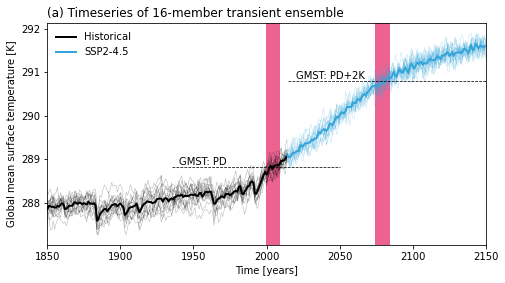

In [4]:
fig,ax = plt.subplots(1,1,figsize=(7,4))
plt.subplots_adjust(left=0.1, bottom=0.13, right=.97, top=0.9)

units = {'tas':'K','pr':'mm'}
colour = '#34A5DA'

## data lines
for i_e in da_reg_period.ens:
    plt.plot(range(1850,2015),da_reg_period.sel(ens=i_e).sel(time=slice(1850,2014)),color='black',linewidth=.5,zorder=10,alpha=.3)
    plt.plot(range(2014,2151),da_reg_period.sel(ens=i_e).sel(time=slice(2014,2150)),color=colour,linewidth=.5,zorder=10,alpha=.3)
plt.plot(range(1850,2015),da_reg_period.mean(dim='ens').sel(time=slice(1850,2014)),color='black',linewidth=2,zorder=10,label='Historical')
plt.plot(range(2014,2151),da_reg_period.mean(dim='ens').sel(time=slice(2014,2150)),color=colour,linewidth=2,zorder=10,label=f"SSP{str(ssp)[0]}-{str(ssp)[1]}.{str(ssp)[2]}")

## annotation
ylim = ax.get_ylim()
# LENTIS time slices
plt.fill_between([1999.5,2009.5],np.repeat(ylim[0],2),np.repeat(ylim[1],2),color='#EC6391',alpha=1,linewidth=0,zorder=0)
plt.fill_between([2074.5,2084.5],np.repeat(ylim[0],2),np.repeat(ylim[1],2),color='#EC6391',alpha=1,linewidth=0,zorder=0)
#plt.text(2004.5,ylim[0]+(ylim[1]-ylim[0])*.04,'PD',fontsize=10,ha='center')
#plt.text(2079.5,ylim[0]+(ylim[1]-ylim[0])*.04,'2K',fontsize=10,ha='center')
# LENTIS GMST values
if region == 'global':
    PD_gmst = da_reg_period.sel(time=slice(2000,2009)).mean().values
    plt.plot([1935,2050],np.repeat(PD_gmst,2),color='black',linewidth=.75,linestyle='--',zorder=20)
    plt.plot([2015,2165],np.repeat(PD_gmst+2,2),color='black',linewidth=.75,linestyle='--',zorder=20)
    plt.text(1940,PD_gmst+.05,'GMST: PD',fontsize=10,ha='left')
    plt.text(2020,PD_gmst+2.05,'GMST: PD+2K',fontsize=10,ha='left')
# legend
plt.legend(loc=2,frameon=False,fontsize=10)
# labels
if region == 'EU':
    plt.ylabel(f"{var.upper()} EU-mean [{units[var]}]")
elif region == 'global':
    if var == 'tas':
        plt.ylabel(f"Global mean surface temperature [{units[var]}]")
    else:
        plt.ylabel(f"{var.upper()} global-mean [{units[var]}]")
plt.xlabel(f"Time [years]")
plt.title(f"(a) Timeseries of 16-member transient ensemble",loc='left')
# axes
plt.ylim(ylim[0],ylim[1])
plt.xlim(1850,2150)

plt.savefig(f"fig_ts_{var.upper()}_SSP{ssp}.pdf")
plt.show()